In [1]:
import numpy as np
from numpy.random import randn
import math
import matplotlib.pyplot as plt

from matplotlib_helper import *

In [2]:
from math import sin, cos, radians

def angle_between(x, y):
    return min(y - x, y - x + 360, y - x - 360, key=abs)

class ManeuveringTarget(object):
    def __init__(self, x0, y0, v0, dt, heading):
        self.x = x0
        self.y = y0
        self.vel = v0
        self.dt = dt
        self.hdg = heading

        self.cmd_vel = v0
        self.cmd_hdg = heading
        self.vel_step = 0
        self.hdg_step = 0
        self.vel_delta = 0
        self.hdg_delta = 0

    def update(self):
        vx = self.vel * cos(radians(90-self.hdg))
        vy = self.vel * sin(radians(90-self.hdg))
        self.x += vx * self.dt
        self.y += vy * self.dt

        if self.hdg_step > 0:
            self.hdg_step -= 1
            self.hdg += self.hdg_delta

        if self.vel_step > 0:
            self.vel_step -= 1
            self.vel += self.vel_delta

        return (self.x, self.y)

    def set_commanded_heading(self, hdg_degrees, interval_time):
        steps = interval_time / self.dt
        self.cmd_hdg = hdg_degrees
        self.hdg_delta = angle_between(self.cmd_hdg, self.hdg) / steps

        if abs(self.hdg_delta) > 0:
            self.hdg_step = steps
        else:
            self.hdg_step = 0

    def set_commanded_speed(self, speed, steps, interval_time):
        steps = interval_time / self.dt
        self.cmd_vel = speed
        self.vel_delta = (self.cmd_vel - self.vel) / steps

        if abs(self.vel_delta) > 0:
            self.vel_step = steps
        else:
            self.vel_step = 0

In [10]:
from numpy.linalg import norm
from math import atan2

class RadarStation:

    def __init__(self, pos, range_std, azimuth_angle_std):
        self.pos = np.asarray(pos)
        self.range_std = range_std
        self.azimuth_angle_std = azimuth_angle_std

    def reading_of(self, ac_pos):
        """ （直距離、仰角）を返す。仰角の単位は、ラジアン。"""
        diff = np.subtract(ac_pos, self.pos)
        rng = norm(diff)
        brg = math.radians(90) - atan2(diff[0], diff[1])
        return rng, brg

    def noisy_reading(self, ac_pos):
        """ シミューレートされたノイズを持った　直距離と仰角の観測値を返す. """
        rng, brg = self.reading_of(ac_pos)
        rng += randn() * self.range_std
        brg += randn() * self.azimuth_angle_std
        return rng, brg

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def generate_data(dt_sec=0.05, steady_count=50, v0_m_sec=1.6, range_std_m=0.2, elevation_angle_std_deg=3):
    t = ManeuveringTarget(x0=0, y0=0, v0=v0_m_sec, dt=dt_sec, heading=0)
    xs, ys = [], []

    for i in range(30):
        x, y = t.update()
        xs.append(x)
        ys.append(y)

    t.set_commanded_heading(50, 0.1)
    #t.set_commanded_speed(1, 2)

    for i in range(steady_count):
        x, y = t.update()
        xs.append(x)
        ys.append(y)

    pos = (0,0)
    #range_std = 5 # 単位はメートル
    elevation_angle_std = math.radians(elevation_angle_std_deg) 
    
    radar = RadarStation(pos, range_std_m, elevation_angle_std)
    
    poss = np.array(list(zip(xs, ys)))    
    zs = np.array([radar.noisy_reading(p) for p in poss])
    
    return poss, zs 

In [12]:
poss, zs = generate_data(dt_sec=0.05, steady_count=50, range_std_m=0.2, elevation_angle_std_deg=3)

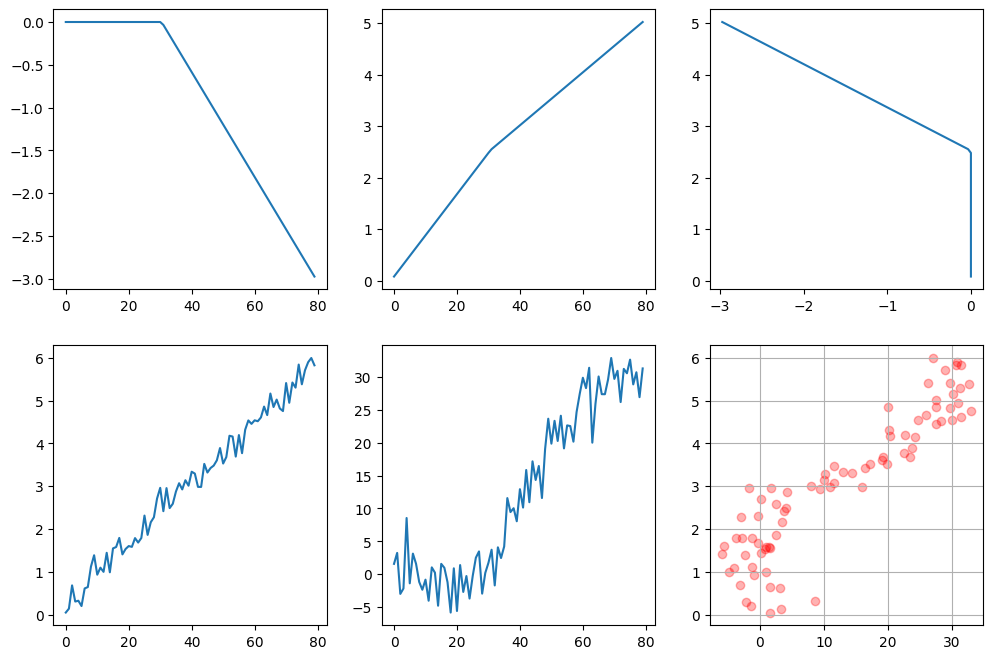

In [13]:
plt.figure(figsize=(12,8))
plt.subplot(231)
plt.plot(poss[:,0])
plt.subplot(232)
plt.plot(poss[:,1])
plt.subplot(233)
plt.plot(*zip(*poss))
plt.subplot(234)
plt.plot(zs[:,0])
plt.subplot(235)
plt.plot(np.degrees(zs[:,1]) - 90)
plt.subplot(236)
plt.scatter(np.degrees(zs[:,1]) - 90, zs[:,0], color="r", alpha=0.3)
plt.grid()

In [14]:
def azimuth_to_xy(rs, azimuths):
    xs = rs * np.cos(azimuths)
    ys = rs * np.sin(azimuths)
    return xs, ys

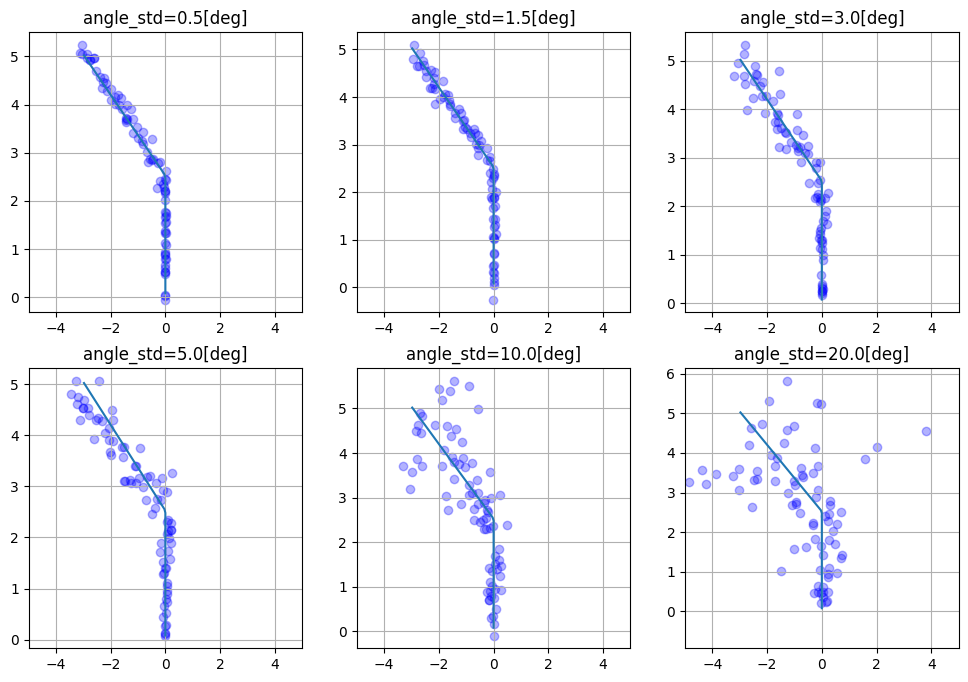

In [15]:
angle_stds = [0.5, 1.5, 3.0, 5.0, 10.0, 20.0]
fig = plt.figure(figsize=(12,8))
for i, angle_std in enumerate(angle_stds):
    poss, zs = generate_data(dt_sec=0.05, steady_count=50, range_std_m=0.2, elevation_angle_std_deg=angle_std)
    
    new_xs, new_ys = azimuth_to_xy(*zip(*zs))

    ax = fig.add_subplot(2, 3, i+1)
    ax.plot(*zip(*poss))
    ax.scatter(new_xs, new_ys, color="b", alpha=0.3)
    ax.set_title(f"angle_std={angle_std}[deg]")
    ax.set_xlim([-5, 5])
    ax.grid()

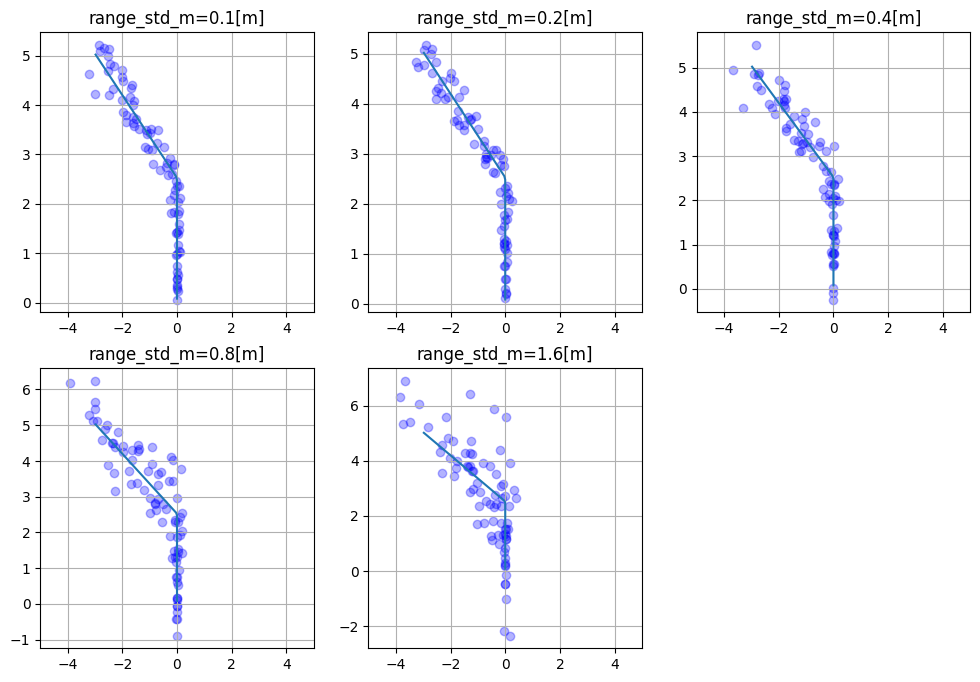

In [16]:
range_std_ms = [0.1, 0.2, 0.4, 0.8, 1.6]
fig = plt.figure(figsize=(12,8))
for i, range_std_m in enumerate(range_std_ms):
    poss, zs = generate_data(dt_sec=0.05, steady_count=50, range_std_m=range_std_m, elevation_angle_std_deg=3.0)
    
    new_xs, new_ys = azimuth_to_xy(*zip(*zs))

    ax = fig.add_subplot(2, 3, i+1)
    ax.plot(*zip(*poss))
    ax.scatter(new_xs, new_ys, color="b", alpha=0.3)
    ax.set_title(f"range_std_m={range_std_m}[m]")
    ax.set_xlim([-5, 5])
    ax.grid()